# Nextbike API data
Initial insight

In [1]:
import sys
sys.path.append('API')
from API import get_data_from_api, transform_api_data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
plt.rcParams['figure.figsize'] = 16,9
plt.rcParams['font.size'] = 18

#### Mongo DB connection:

In [2]:
client = get_data_from_api.create_mong_client()

In [3]:
db = client['bda']

Number of documents in the collection:

In [4]:
db.bikes.count_documents({})

4785

Exemplary document:

In [5]:
import psycopg2

In [6]:
conn = psycopg2.connect("dbname='...' user='...' host='...' password='...'")

In [7]:
conn

<connection object at 0x0000025A1D961370; dsn: 'user=postgres password=xxx dbname=bda-2022-nextbike-data host=34.118.39.208', closed: 0>

In [8]:
records = db.bikes.find({}, {}).limit(5)

Data structure:

In [9]:
record = next(records)
record

{'_id': ObjectId('639f4ae110d137f3f0c53339'),
 'countries': [{'name': 'nextbike Austria',
   'country_name': 'Austria',
   'booked_bikes': 0,
   'set_point_bikes': 0,
   'available_bikes': 0,
   'cities': []},
  {'name': 'nextbike New Zealand',
   'country_name': 'New Zealand',
   'booked_bikes': 0,
   'set_point_bikes': 91,
   'available_bikes': 8,
   'cities': [{'uid': 193,
     'name': 'Christchurch',
     'available_bikes': 8,
     'num_places': 2,
     'booked_bikes': 0,
     'set_point_bikes': 40,
     'places': [{'uid': 3357512,
       'lat': -43.538407,
       'lng': 172.643505,
       'bikes_available_to_rent': 6,
       'bike_racks': 10,
       'free_racks': 3,
       'special_racks': 0,
       'bike_numbers': ['64326', '64320', '64311', '64309', '64308', '64303'],
       'name': 'Ara City Campus',
       'booked_bikes': 0,
       'bikes': 6,
       'free_special_racks': 0},
      {'uid': 5104038,
       'lat': -43.548144,
       'lng': 172.662377,
       'bikes_available_to_

In [10]:
record.keys()

dict_keys(['_id', 'countries'])

The dataset is of a deeply nested structure. The first level contains only three keys: `_id`, `countries`, `timestamp`. The second key points to the list of companies serving the rentals with keys: `name`, `country_name`, `booked_bikes`, `set_point_bikes`, `available_bikes` and `cities`. The last one is another level with lists containing data of particular systems, including data about specific bike rentals

The documentation does not refer to any technique of handling the missing data. Basing on the data, we assume that the structure is unchangeable, instead some fields might contain 0s as values or empty lists.

Statistics of number of systems in all countries in the exemplary document:

In [11]:
list(map(lambda x: (x['name'], len(x['cities'])), record['countries']))

[('nextbike Austria', 0),
 ('nextbike New Zealand', 2),
 ('nextbike Niederösterreich Austria', 17),
 ('nextbike Switzerland', 17),
 ('nextbike LV', 1),
 ('WRM nextbike Poland', 1),
 ('metropolradruhr Germany', 10),
 ('nextbike Cyprus', 3),
 ('PRM Poznan Poland', 0),
 ('Opole Bike Poland', 0),
 ('VETURILO Poland', 0),
 ('nextbike Stirling', 1),
 ('nextbike Croatia', 3),
 ('Demoland', 6),
 ('Stadtrad Innsbruck Austria', 1),
 ('Nextbike Poland ', 0),
 ('KVV.nextbike', 7),
 ('BIKER Białystok Poland', 1),
 ('BelfastBikes', 1),
 ('KRM Konstanciński Poland', 0),
 ('Grad Šibenik (Croatia)', 1),
 ('LRM Lublin Poland', 3),
 ('GRM Grodzisk Poland', 0),
 ('VRNnextbike', 22),
 ('nextbike Prostejov', 1),
 ('KVB Rad Germany', 1),
 ('nextbike (Ukraine)', 6),
 ('nextbike business Germany', 0),
 ('Katowice Bike Poland', 0),
 ('nextbike Malta', 1),
 ('Grad Karlovac (Croatia)', 1),
 ('Grad Slavonski Brod (Croatia)', 1),
 ('Heraeus Hanau', 1),
 ('nextbike Romania', 1),
 ('Santander Cycles - Milton Keynes',

### One, particular city rental system visualization
The goal of the notebook's following part is to provide an initial possible visualization of the stations usage. This will be carried out for a specific rental system.

In [12]:
cityname = "Karlsruhe"
city_uid = 21

Collecting the data from mongo

In [13]:
r = db.bikes.aggregate([
      {"$unwind":"$countries"},
      {"$unwind":"$countries.cities"}, 
      {"$match":
       {"countries.cities.name": cityname,
        "countries.cities.uid": city_uid}
      }
])

#### Data transformation

Aggregating the following states of stations to the shape with statistics about returns and collections

First of all, let's extract the data with rows at the stations level.

In [14]:
dfs = [pd.DataFrame(transform_api_data.add_timestamp_to_dict(r_t)) for r_t in r]
df = pd.concat(dfs)

df

uid        lat       lng  bikes_available_to_rent  bike_racks  \
0          458  49.007126  8.402725                        0           0   
1         1390  49.008694  8.395077                        0           0   
2       264394  48.994617  8.400361                       59           0   
3       264579  49.027000  8.453540                        2           0   
4       280249  49.010834  8.395102                        0           0   
..         ...        ...       ...                      ...         ...   
487  139255870  49.011271  8.433625                        1           0   
488  139255971  49.003053  8.387797                        1           0   
489  139256003  49.059800  8.473094                        1           0   
490  139256016  48.992293  8.473287                        1           0   
491  139256062  49.003996  8.355579                        1           0   

     free_racks  special_racks  \
0             0              0   
1             0              0   
2             0              0   
3             0              0   
4             0              0   
..          ...            ...   
487           0              0   
488           0              0   
489           0              0   
490           0              0   
491           0              0   

                                          bike_numbers  \
0                                                   []   
1                                                   []   
2    [54049, 54144, 54161, 54195, 54266, 54281, 543...   
3                                       [54568, 54438]   
4                                                   []   
..                                                 ...   
487                                            [54782]   
488                                            [54305]   
489                                            [54407]   
490                                            [54544]   
491                                            [54623]   

                                  name  booked_bikes  bikes  \
0                       Erbprinzenstr.             0      0   
1              Karlstraße / Waldstraße             0      0   
2    Hauptbahnhof / Touristinformation             0     59   
3                     Bahnhof Hagsfeld             0      2   
4                     Prinz-Max-Palais             0      0   
..                                 ...           ...    ...   
487                         BIKE 54782             0      1   
488                         BIKE 54305             0      1   
489                         BIKE 54407             0      1   
490                         BIKE 54544             0      1   
491                         BIKE 54623             0      1   

     free_special_racks               timestamp country_name  city_uid  \
0                     0 1970-01-01 00:00:00.000      Germany        21   
1                     0 1970-01-01 00:00:00.000      Germany        21   
2                     0 1970-01-01 00:00:00.000      Germany        21   
3                     0 1970-01-01 00:00:00.000      Germany        21   
4                     0 1970-01-01 00:00:00.000      Germany        21   
..                  ...                     ...          ...       ...   
487                   0 2023-01-03 20:40:02.958      Germany        21   
488                   0 2023-01-03 20:40:02.958      Germany        21   
489                   0 2023-01-03 20:40:02.958      Germany        21   
490                   0 2023-01-03 20:40:02.958      Germany        21   
491                   0 2023-01-03 20:40:02.958      Germany        21   

     city_name  
0    Karlsruhe  
1    Karlsruhe  
2    Karlsruhe  
3    Karlsruhe  
4    Karlsruhe  
..         ...  
487  Karlsruhe  
488  Karlsruhe  
489  Karlsruhe  
490  Karlsruhe  
491  Karlsruhe  

[2344023 rows x 16 columns]

In the data, there are plenty of temporary stations that are used only for limited time. This apparently refers to the model of the system. Bikes might be returned in any place in a given area.

Let's focus on the stations that are available in each document.

In [15]:
stations = df.uid.value_counts()[df.uid.value_counts()==len(dfs)].index

In [16]:
df = df.loc[df['uid'].isin(stations)]

In [17]:
df = transform_api_data.add_related_columns(df)

In [18]:
x = df.apply(transform_api_data.calculate_usage, axis=1, result_type='expand')

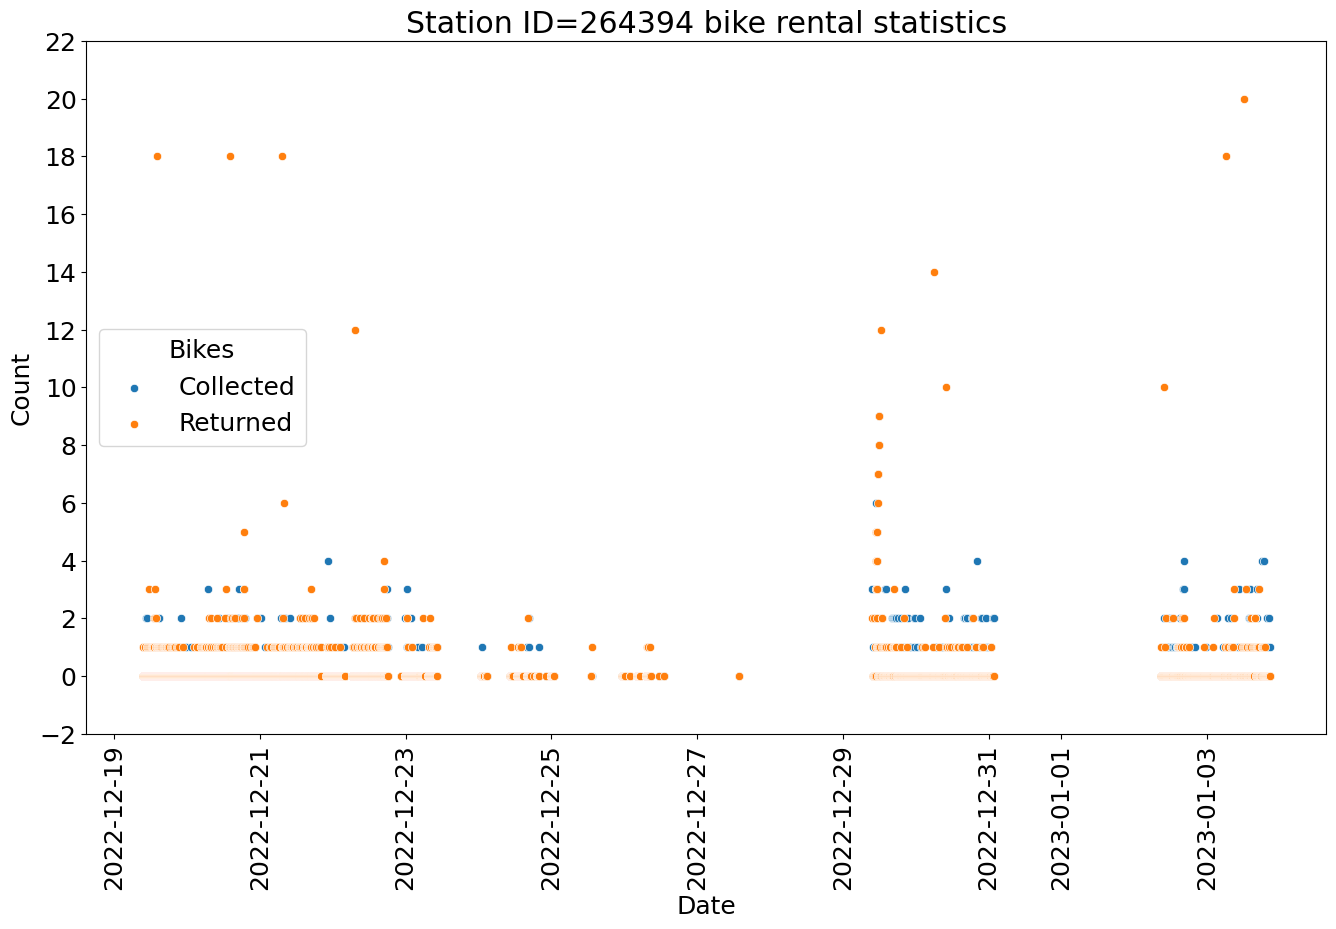

In [19]:
station_uid = 264394
station_df = x.loc[(x.uid==station_uid) & x.valid,]
fig, ax = plt.subplots()
sns.scatterplot(x = 'timestamp_end', y='collected', data = station_df, label='Collected', ax=ax)
sns.scatterplot(x = 'timestamp_end', y='returned', data = station_df, label='Returned', ax=ax)
l = plt.legend()
l.set_title("Bikes")
plt.yticks(np.arange(ax.get_yticks().min().round(), ax.get_yticks().max(), 2))
plt.ylabel('Count')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.title(f'Station ID={station_uid} bike rental statistics')
plt.show()
plt.show()

In [20]:
station_df.returned.max()

20

Data aggregation on the city level

In [21]:
agg_x = x.loc[x.valid, :].groupby('timestamp_end').aggregate({'returned': 'sum', 'collected': 'sum'})

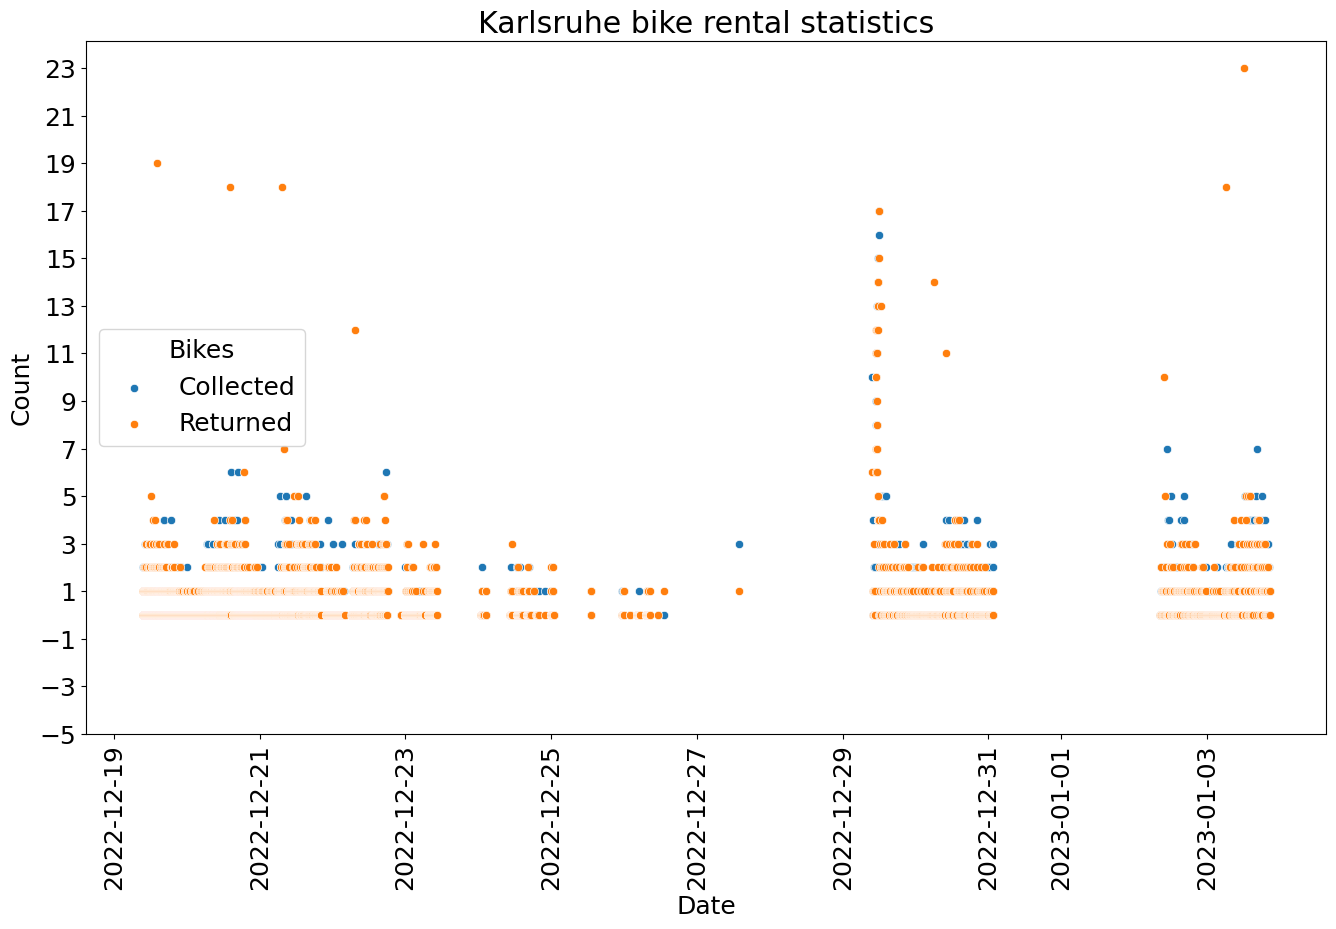

In [22]:
fig, ax = plt.subplots()
sns.scatterplot(x = 'timestamp_end', y='collected', data = agg_x, label='Collected', ax=ax)
sns.scatterplot(x = 'timestamp_end', y='returned', data = agg_x, label='Returned', ax=ax)
l = plt.legend()
l.set_title("Bikes")
plt.yticks(np.arange(ax.get_yticks().min().round(), ax.get_yticks().max(), 2))
plt.ylabel('Count')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.title(f'{cityname} bike rental statistics')
plt.show()

Importance of stations in a given period

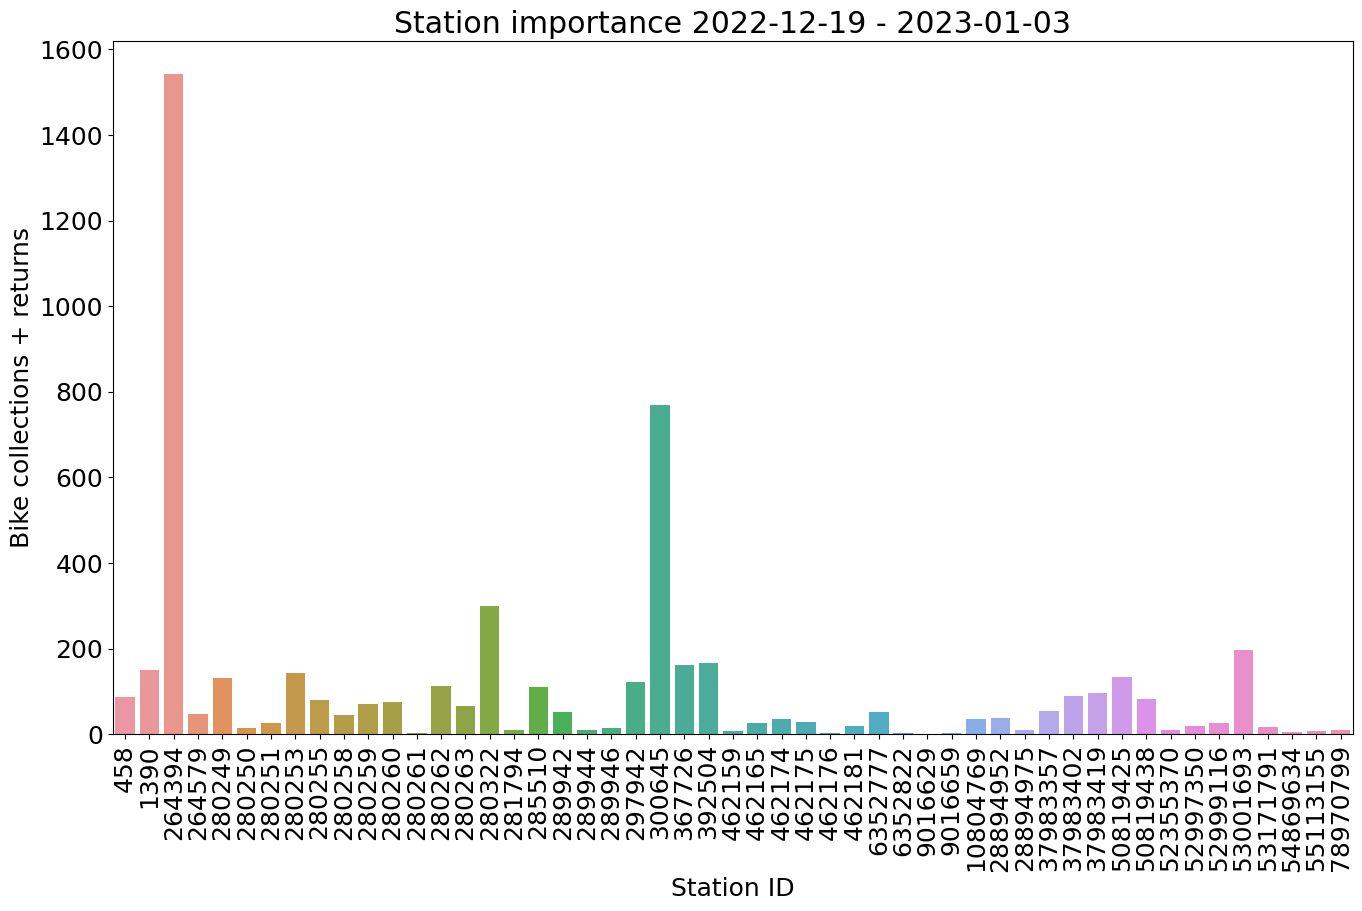

In [23]:
station_importance = x.loc[x.valid].groupby('uid').agg(
    {'collected': 'sum', 'returned': 'sum', 'timestamp_end': 'last', 'timestamp_start': 'first', 'lng': 'first', 'lat': 'first'}
).reset_index()
station_importance['actions'] = station_importance['collected'] + station_importance['returned']
sns.barplot(x='uid', y='actions', data = station_importance)
plt.xticks(rotation=90)
plt.xlabel('Station ID')
plt.ylabel('Bike collections + returns')
plt.title(f'Station importance {station_importance["timestamp_start"].dt.date.iloc[0]} - {station_importance["timestamp_end"].dt.date.iloc[0]}')
plt.show()